In [1]:
import tensorflow as tf

/home/kidist/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kidist/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kidist/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kidist/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dty

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:

# ploat an image
def plot_image(image_arr):
    fig,axes = plt.subplots(1,5,figsize=(20,20))
    axes = axes.flatten()
    for img,ax in zip(image_arr,axes):
        ax.imshow(img)
        plt.tight_layout()
    plt.show()
        
    

In [4]:
# getting data
base_dir  = 'cat-and-dog'
train_dir = os.path.join(base_dir,"training_set","training_set")
test_dir = os.path.join(base_dir,"test_set","test_set")

train_cats = os.path.join(train_dir,"cats")
train_dogs = os.path.join(train_dir,"dogs")
test_cats = os.path.join(test_dir,"cats")
test_dogs = os.path.join(test_dir,"dogs")

num_cats_train = len(os.listdir(train_cats))
num_dogs_train = len(os.listdir(train_dogs))
num_cats_test = len(os.listdir(test_cats))
num_dogs_test= len(os.listdir(test_dogs))

total_num_train = num_cats_train + num_dogs_train
total_num_test = num_cats_test + num_dogs_test

print(num_cats_train)
print(num_cats_test)
print(total_num_train)
print(total_num_test)

4001
1012
8007
2025


In [5]:
Batch_size = 32
image_shape = 150

In [6]:

train_image_generator = ImageDataGenerator(
    # image augmentation
    rotation_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip=True,
    rescale = 1./255 #normalize the image 
             )
test_image_generator = ImageDataGenerator(
    rescale = 1./255
             )

In [7]:
train_image_gen = train_image_generator.flow_from_directory(
batch_size = Batch_size,
directory = train_dir,
shuffle = True,
target_size = (image_shape,image_shape),
class_mode= "binary")

Found 8005 images belonging to 2 classes.


In [8]:
test_image_gen =test_image_generator.flow_from_directory(
batch_size = Batch_size,
directory = test_dir,
shuffle = False,
target_size = (image_shape,image_shape),
class_mode= "binary")

Found 2023 images belonging to 2 classes.


In [9]:
train_image_gen.class_indices

{'cats': 0, 'dogs': 1}

In [10]:
print(train_image_gen[0][0].shape)
print(train_image_gen[0][1].shape)
print(train_image_gen[0][0][0].shape)

(32, 150, 150, 3)
(32,)
(150, 150, 3)


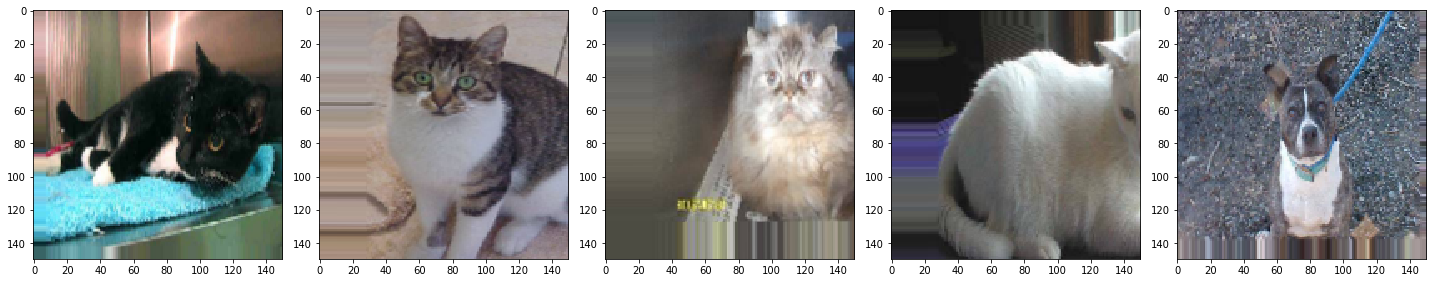

In [11]:
plot_image([train_image_gen[i][0][0] for i in range(5)])

In [12]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(image_shape, image_shape, 3)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
dropout (Dropout)            (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        3

In [14]:
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
              metrics = ['accuracy']
              
             )


In [15]:
n_epoch = 30
history = model.fit_generator(
train_image_gen,
steps_per_epoch=int(np.ceil(total_num_train/float(Batch_size))),
epochs = n_epoch,
validation_data = test_image_gen,
validation_steps= int(np.ceil(total_num_test/float(Batch_size)))
)


Epoch 1/30
251/251 [==============================] - 221s 879ms/step - loss: 0.6912 - accuracy: 0.5268 - val_loss: 0.6856 - val_accuracy: 0.5299
Epoch 2/30
251/251 [==============================] - 216s 861ms/step - loss: 0.6797 - accuracy: 0.5493 - val_loss: 0.6596 - val_accuracy: 0.6209
Epoch 3/30
251/251 [==============================] - 184s 733ms/step - loss: 0.6748 - accuracy: 0.5863 - val_loss: 0.6820 - val_accuracy: 0.6085
Epoch 4/30
251/251 [==============================] - 178s 711ms/step - loss: 0.6517 - accuracy: 0.6246 - val_loss: 0.6241 - val_accuracy: 0.6545
Epoch 5/30
251/251 [==============================] - 215s 855ms/step - loss: 0.6222 - accuracy: 0.6461 - val_loss: 0.6236 - val_accuracy: 0.6569
Epoch 6/30
251/251 [==============================] - 199s 794ms/step - loss: 0.5941 - accuracy: 0.6851 - val_loss: 0.5849 - val_accuracy: 0.6911
Epoch 7/30
251/251 [==============================] - 212s 846ms/step - loss: 0.5783 - accuracy: 0.7049 - val_loss: 0.5273 -

In [16]:
model.history

In [17]:
loss = model.history.history["loss"]
val_loss = model.history.history["val_loss"]
acc = model.history.history["accuracy"]
val_acc = model.history.history["val_accuracy"]

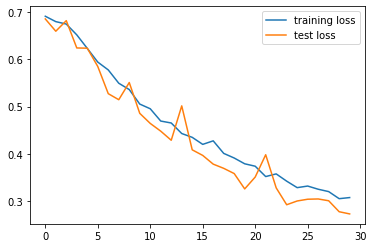

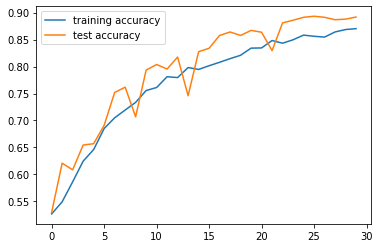

In [18]:
plt.plot(loss, label="training loss")
plt.plot(val_loss,  label="test loss")
plt.legend()
plt.show()
plt.plot(acc, label="training accuracy")
plt.plot(val_acc,  label="test accuracy")
plt.legend()
plt.show()

In [19]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [20]:
image = load_img("my-test-imgs/1.png", target_size=(image_shape, image_shape)) # load image and resize it to target_size

In [21]:
type(image)

PIL.Image.Image

In [22]:
img = img_to_array(image) # convert PIL image to numpy array.

In [23]:
type(img)

numpy.ndarray

In [24]:
print(img.shape)

(150, 150, 3)


In [25]:
img = np.expand_dims(img, 0) # to add batch dimension.

In [26]:
img = img.astype(np.float32)/255.0 # normalize image

In [27]:
print(img.shape)

(1, 150, 150, 3)


In [28]:
model.predict(img)

array([[0.01185157]], dtype=float32)

In [29]:
img0 = load_img("my-test-imgs/0.jpeg",target_size=(image_shape,image_shape))
img0 = img_to_array(img0)
img0 = np.expand_dims(img0,0)
img0 = img0.astype(np.float32)/255.0
model.predict(img0)

array([[0.45930275]], dtype=float32)

In [30]:
def load_images(folder):
    outputs = []
    for f in os.listdir(folder):
        print(f)
        img = load_img(os.path.join(folder, f),target_size=(image_shape,image_shape))
        img = img_to_array(img)
        img = np.expand_dims(img,0)
        img = img.astype(np.float32)/255.0
        outputs.append(img)
    return np.concatenate(outputs)

In [31]:
def predict_classes(model, images, classes):
    output = []
    prediction = model.predict(images)

    class_label = {value:key for key, value in classes.items()}
    for p in prediction:
        if p> 0.5:
            output.append(class_label[1])
        else:
            output.append(class_label[0])
    return output

In [32]:
images = load_images("my-test-imgs")

2.jpeg
3.jpeg
0.jpeg
1.png


In [33]:
predict_classes(model, images, train_image_gen.class_indices)

['dogs', 'dogs', 'cats', 'cats']

In [34]:
def predict_and_plot(model, image_folder):
    class2index = train_image_gen.class_indices
    index2class = {value:key for key, value in class2index.items()}
    image_files = os.listdir(image_folder)
    fig,axes = plt.subplots(1,4,figsize=(20,20))
    axes = axes.flatten()
    for i in range(len(image_files)):
        image_file = image_files[i]
        img = load_img(os.path.join(image_folder, image_file),target_size=(image_shape,image_shape))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array,0)
        img_array = img_array.astype(np.float32)/255.0
        
        prediction = model.predict_classes(img_array.reshape(-1, image_shape, image_shape, 3))[0][0]

        axes[i].set_title("predicted:"+index2class[prediction])
        img_array = img_to_array(img)
        
        axes[i].imshow(img_array.astype(np.uint8))
        plt.tight_layout()
 
    
        
    plt.show()

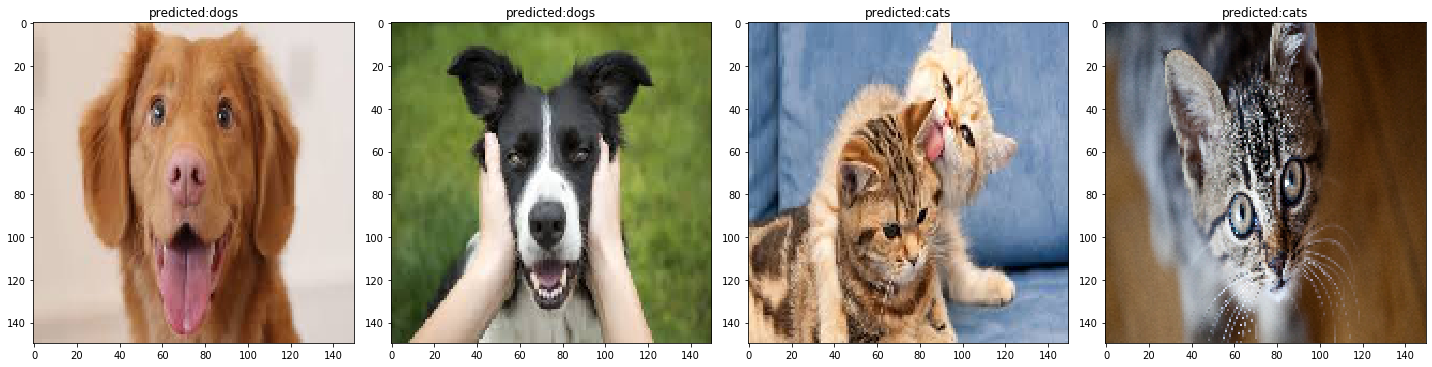

In [35]:
predict_and_plot(model, 'my-test-imgs')